In [0]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
os.environ['KERAS_BACKEND'] = "tensorflow"
#TensorFlow: Channels last order.
#Theano: Channels first order.
#CNTK: Channels last order.

In [2]:
import matplotlib
#from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import imageio as im
from keras import models #vamos precisar desta biblioteca para aceder às camadas do modelo
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras import backend as K
#K.set_image_dim_ordering('tf') 
K.image_data_format() == 'channels_last'
from keras.utils import np_utils
from keras.utils.data_utils import get_file
#from keras.datasets import mnist


Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)


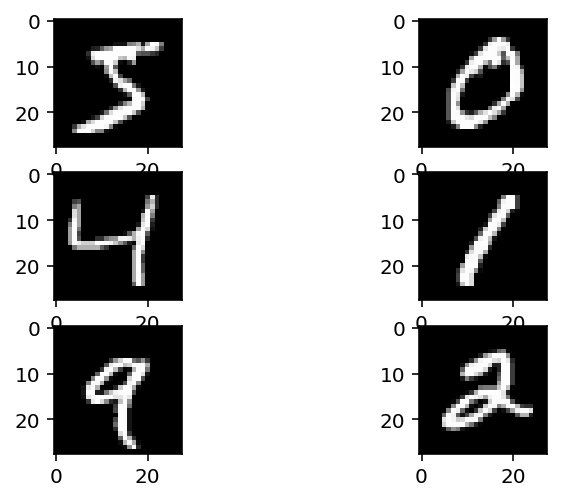

shape[0]:  60000
shape antes:  (60000, 28, 28)
shape depois:  (60000, 28, 28, 1)


In [3]:
# Visualizar 6 imagens do mnist numa escala de cinzentos
def load_mnist_dataset(path='mnist.npz'):
    path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)

def visualize_mnist(X_train):
    #(X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    plt.subplot(321)
    plt.imshow(X_train[0], cmap='gray')
    plt.subplot(322)
    plt.imshow(X_train[1], cmap='gray')
    plt.subplot(323)
    plt.imshow(X_train[2], cmap='gray')
    plt.subplot(324)
    plt.imshow(X_train[3], cmap='gray')
    plt.subplot(325)
    plt.imshow(X_train[4], cmap='gray')
    plt.subplot(326)
    plt.imshow(X_train[5], cmap='gray')
    plt.show()
    
def data_preparation():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    print(X_train.shape)
    visualize_mnist(X_train)
    # transformar para o formato [instancias][pixeis][largura][altura]
    print("shape[0]: ",X_train.shape[0])
    print("shape antes: ",X_train.shape)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
    print("shape depois: ",X_train.shape)
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    return X_train, X_test, y_train, y_test, num_classes

X_train, X_test, y_train, y_test, num_classes = data_preparation() 
    

In [0]:
def create_model_cnn_plus(num_classes):
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def create_model_cnn_plus_plus(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape = (28, 28, 1), activation = 'relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) 
    model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) 
    model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) 
    model.add(Flatten())
    model.add(Dense( 512, activation = 'relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(num_classes, activation = 'softmax'))
    return model

model = create_model_cnn_plus_plus(num_classes)

Vamos visualisar a arquitetura do modelo:

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)         

In [0]:
# Compile model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'categorical_crossentropy',optimizer = 'rmsprop', metrics = ['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5_t1", monitor = 'val_accuracy', verbose=1, save_best_only=True)

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=1, callbacks=[checkpointer])  

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 12s 205us/step - loss: 0.7818 - accuracy: 0.7424 - val_loss: 0.1048 - val_accuracy: 0.9688

Epoch 00001: val_accuracy improved from -inf to 0.96880, saving model to best_weights.hdf5
Epoch 2/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.2188 - accuracy: 0.9372 - val_loss: 0.0549 - val_accuracy: 0.9840

Epoch 00002: val_accuracy improved from 0.96880 to 0.98400, saving model to best_weights.hdf5
Epoch 3/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.1443 - accuracy: 0.9606 - val_loss: 0.0390 - val_accuracy: 0.9891

Epoch 00003: val_accuracy improved from 0.98400 to 0.98910, saving model to best_weights.hdf5
Epoch 4/20
60000/60000 [==============================] - 6s 96us/step - loss: 0.1109 - accuracy: 0.9693 - val_loss: 0.0299 - val_accuracy: 0.9914

Epoch 00004: val_accuracy improved from 0.98910 to 0.99140, saving model to b

In [0]:
model.load_weights('best_weights_t1.hdf5')

In [0]:
model.save('mnist_cnn_t1.h5')

Vamos visualizar o comportamento da rede durante o periodo de treino:

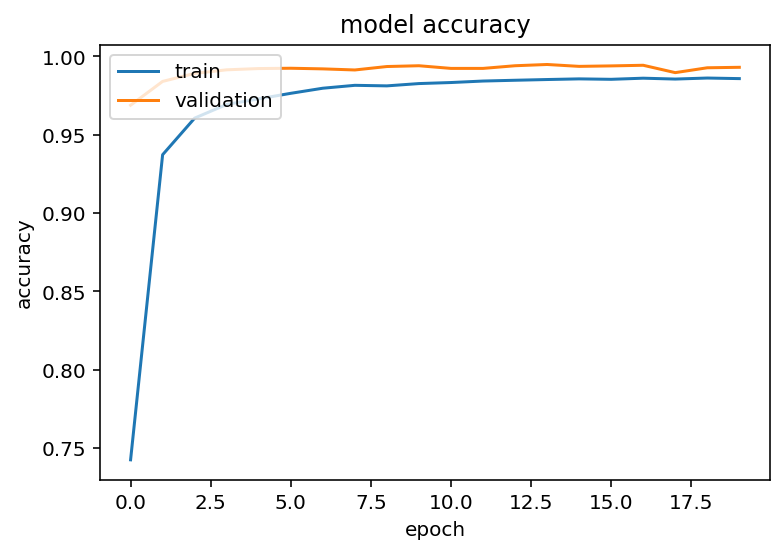

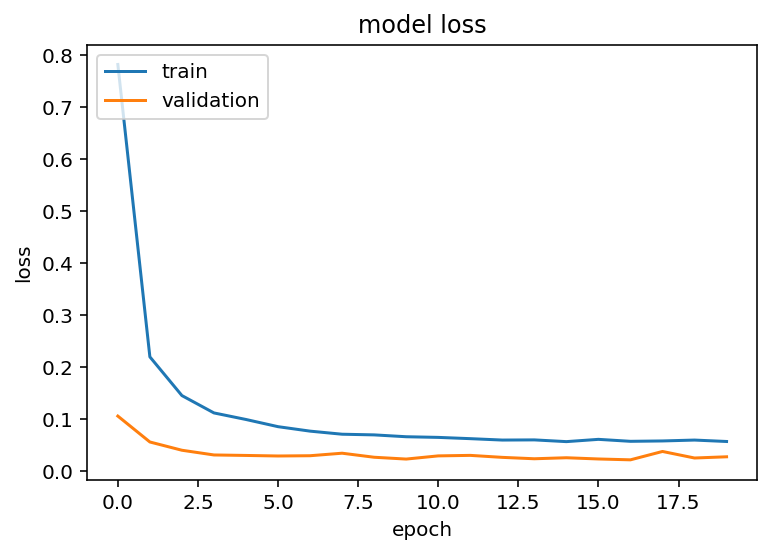

In [11]:
#funções para visulização do historial de aprendizagem
def print_history_accuracy(history):
    #print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def print_history_loss(history):
    #print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

print_history_accuracy(history)
print_history_loss(history)

X_test: (10000, 28, 28, 1)
y_test: (10000, 10)
Imagem: (28, 28, 1)


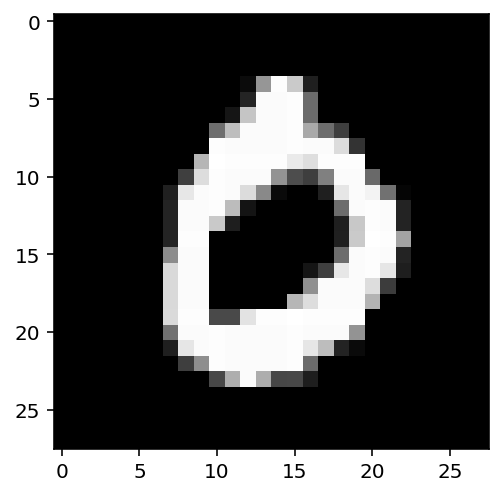

label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
antes do aumento de mais uma dimensão: (28, 28, 1)
depois do aumento de mais uma dimensão: (1, 28, 28, 1)
previsão: [[9.99994516e-01 1.71557369e-11 3.72410653e-08 3.69821673e-10
  5.00154513e-08 1.76119457e-08 1.75192588e-06 1.11087683e-09
  1.05175815e-07 3.58300645e-06]]
Classe prevista: [0]


In [12]:
# Visualizar imagem, label e correspondente previsão
def visualize_previsao(x_test, y_test, img_a_mostrar):
    print("X_test:",x_test.shape)
    print("y_test:",y_test.shape)
    print("Imagem:",x_test[img_a_mostrar].shape)
    plt.imshow(x_test[img_a_mostrar,:,:,0], cmap='gray')
    plt.show()
    print("label:",y_test[img_a_mostrar])
    print("antes do aumento de mais uma dimensão:",x_test[img_a_mostrar].shape)
    imagem_tensor = np.expand_dims(x_test[img_a_mostrar], axis=0)
    print("depois do aumento de mais uma dimensão:",imagem_tensor.shape)
    print("previsão:",model.predict(imagem_tensor))
    classes = model.predict_classes(imagem_tensor)
    print('Classe prevista:',classes)
    return imagem_tensor


imagem_tensor = visualize_previsao(X_test, y_test, 3)

In [13]:
#Vamos buscar os outputs das primeiras 5 (plus) camadas da rede ou 12 para a plus_plus
camadas_outputs = []
for layer in model.layers[:12]:
    print(layer.output.shape)
    camadas_outputs.append(layer.output)

# e depois criamos um modelo que retorna estes outputs dado os inputs do modelo
activation_model = models.Model(inputs=model.input, outputs=camadas_outputs) 

(None, 28, 28, 32)
(None, 26, 26, 32)
(None, 13, 13, 32)
(None, 13, 13, 32)
(None, 13, 13, 64)
(None, 11, 11, 64)
(None, 5, 5, 64)
(None, 5, 5, 64)
(None, 5, 5, 64)
(None, 3, 3, 64)
(None, 1, 1, 64)
(None, 1, 1, 64)


In [0]:
activations = activation_model.predict(imagem_tensor) 
# Retorna uma lista com dois Numpy arrays: um array por camada de ativação

In [15]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


trata-se de um feature map de 28 × 28 com 32 FeatureMaps. Vamos visualizar o 10º FeatureMap de ativação da ativação da primeira camada do modelo original.

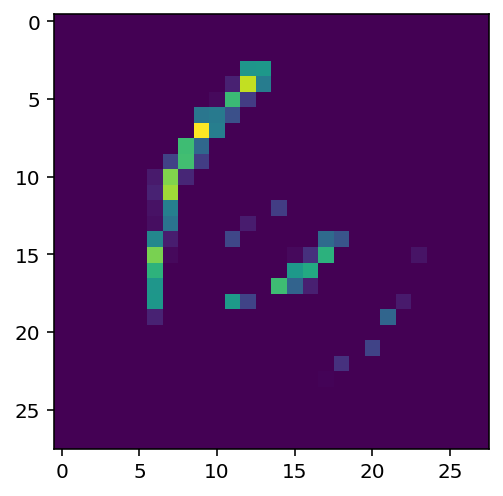

In [22]:
plt.imshow(first_layer_activation[0, :, :, 9], cmap='viridis')
plt.show()

nome_camada: conv2d_1
n_features: 32
size: 28
n_linhas: 2
nome_camada: conv2d_2
n_features: 32
size: 26
n_linhas: 2
nome_camada: max_pooling2d_1
n_features: 32
size: 13
n_linhas: 2
nome_camada: dropout_1
n_features: 32
size: 13
n_linhas: 2
nome_camada: conv2d_3
n_features: 64
size: 13
n_linhas: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


nome_camada: conv2d_4
n_features: 64
size: 11
n_linhas: 4
nome_camada: max_pooling2d_2
n_features: 64
size: 5
n_linhas: 4
nome_camada: dropout_2
n_features: 64
size: 5
n_linhas: 4
nome_camada: conv2d_5
n_features: 64
size: 5
n_linhas: 4
nome_camada: conv2d_6
n_features: 64
size: 3
n_linhas: 4
nome_camada: max_pooling2d_3
n_features: 64
size: 1
n_linhas: 4
nome_camada: dropout_3
n_features: 64
size: 1
n_linhas: 4


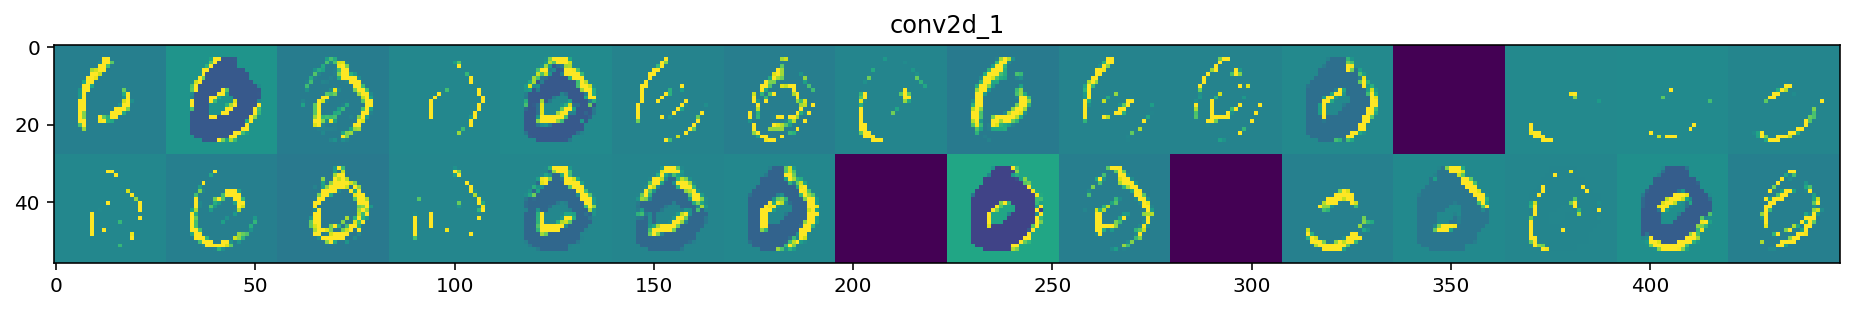

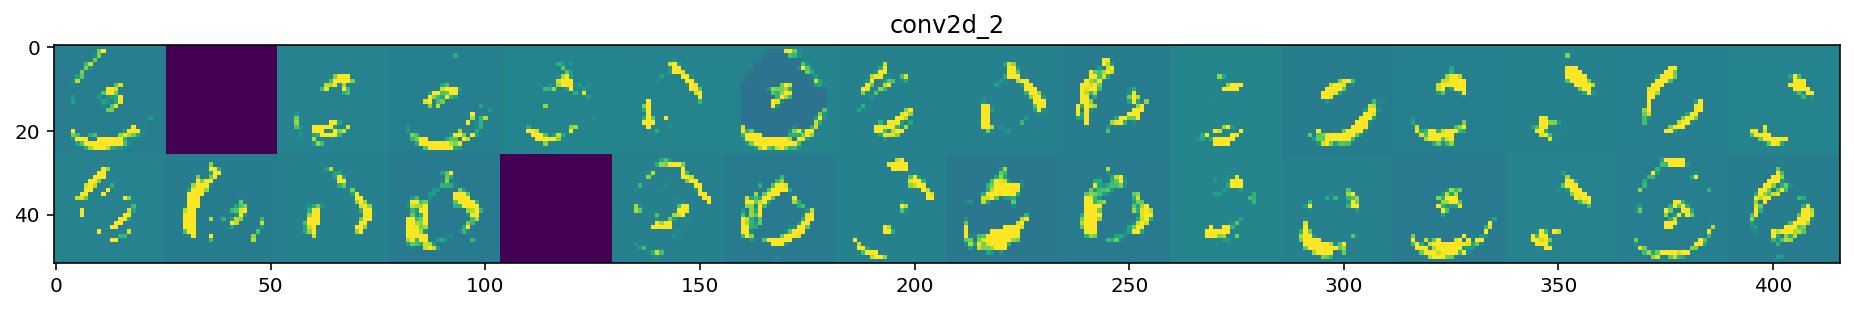

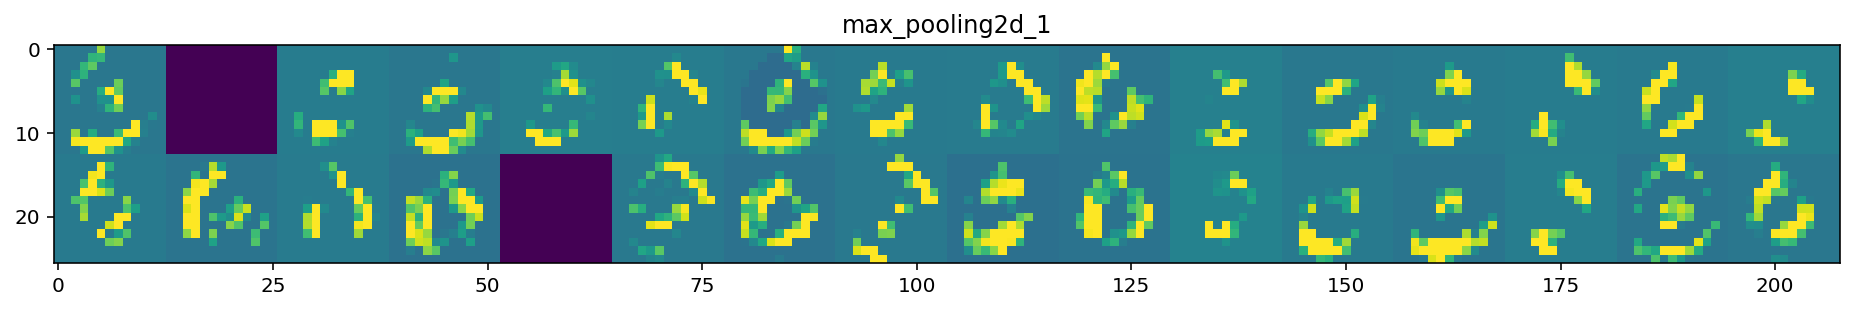

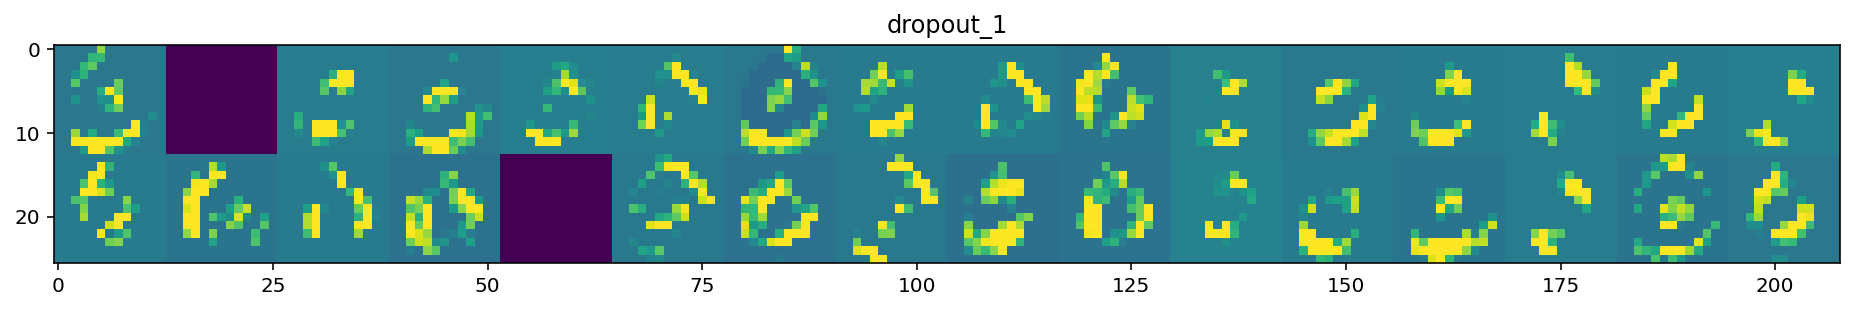

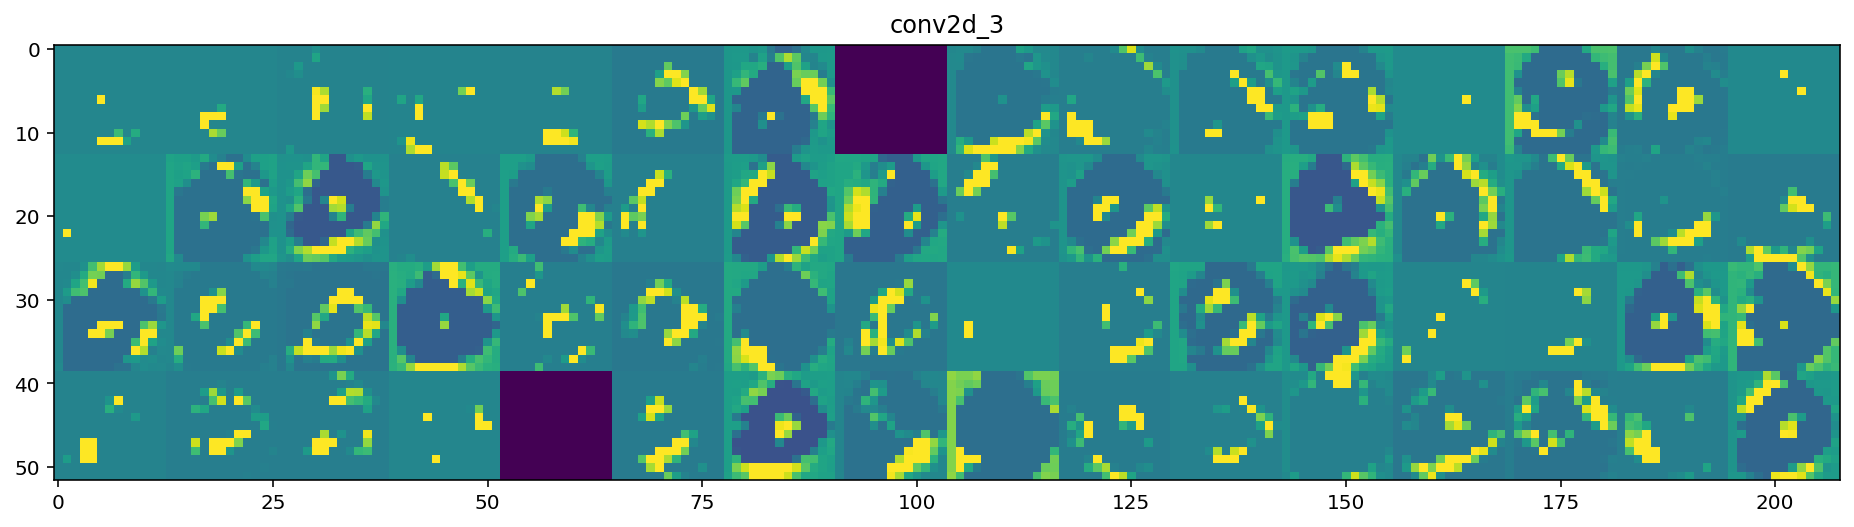

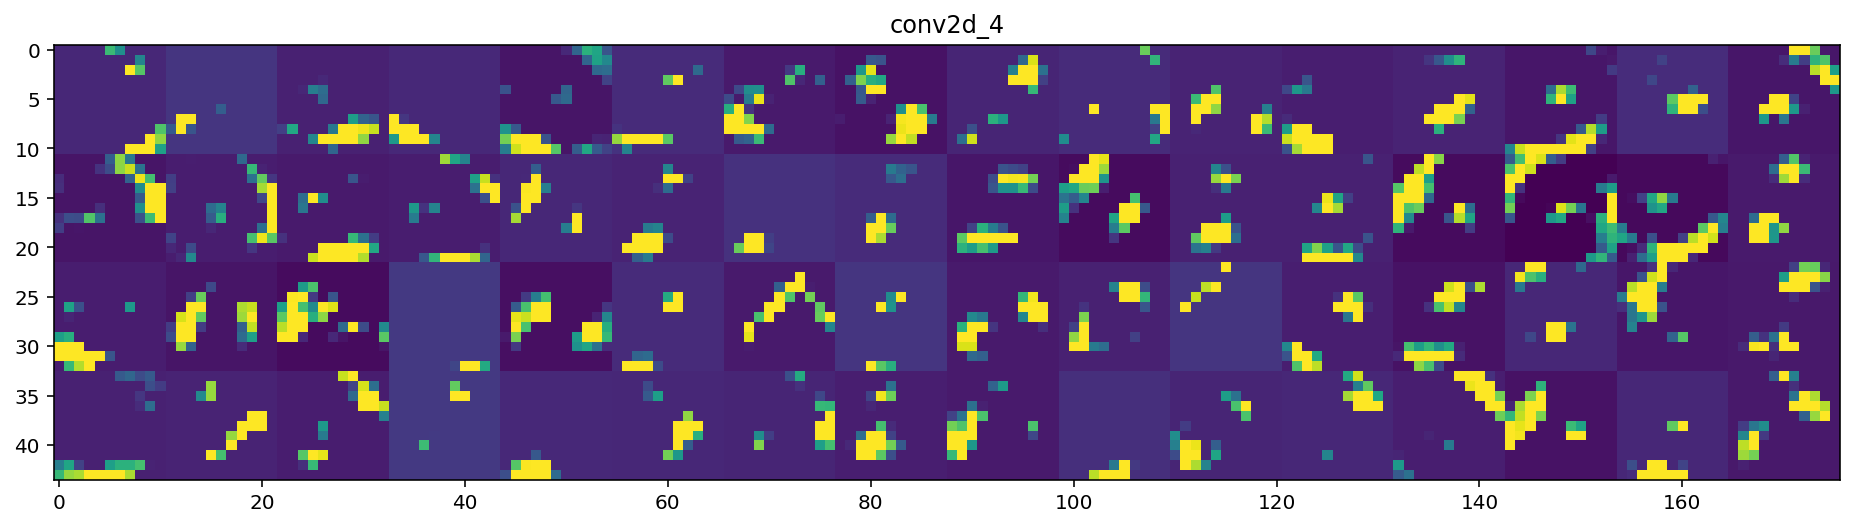

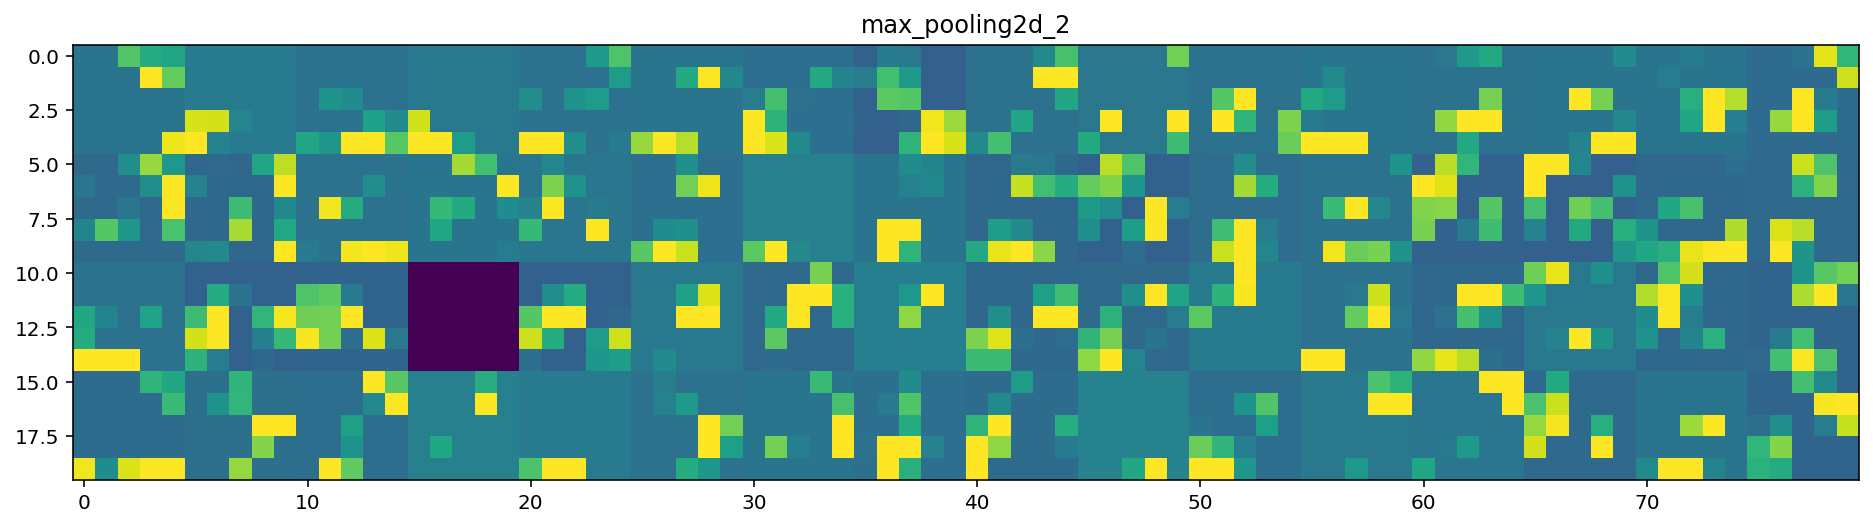

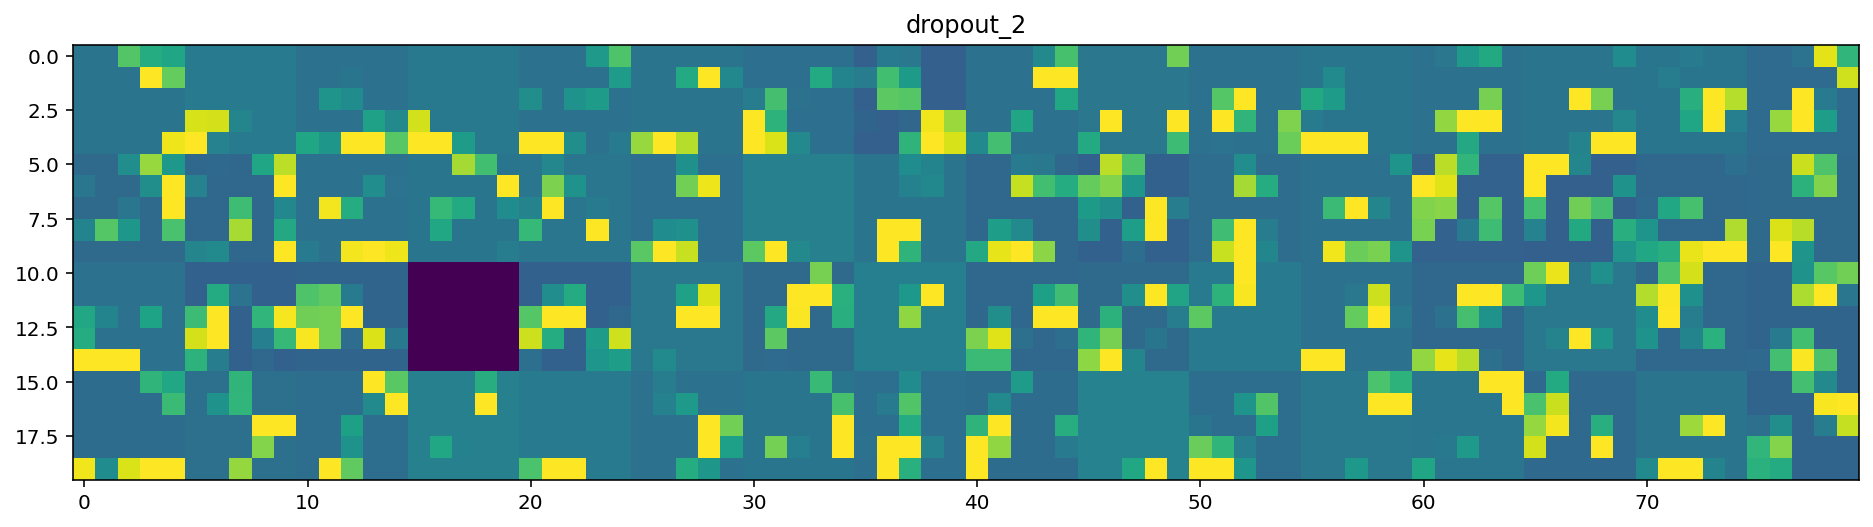

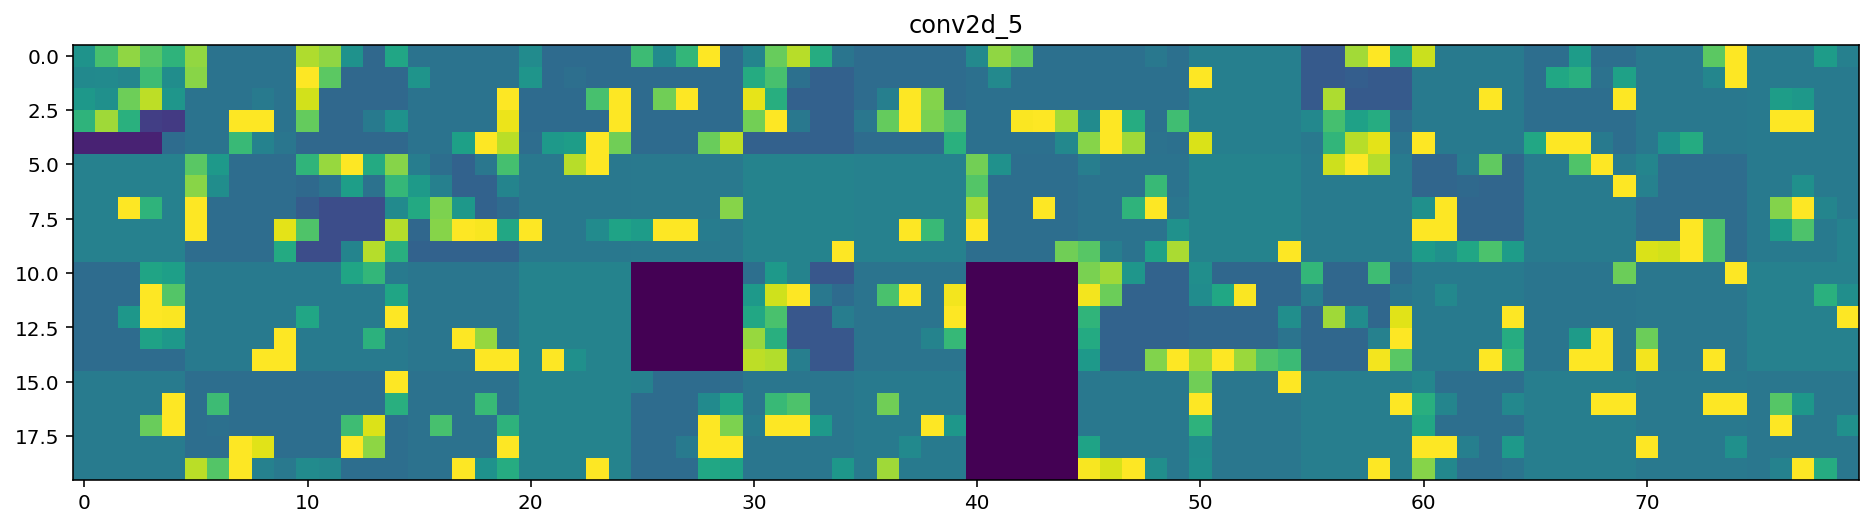

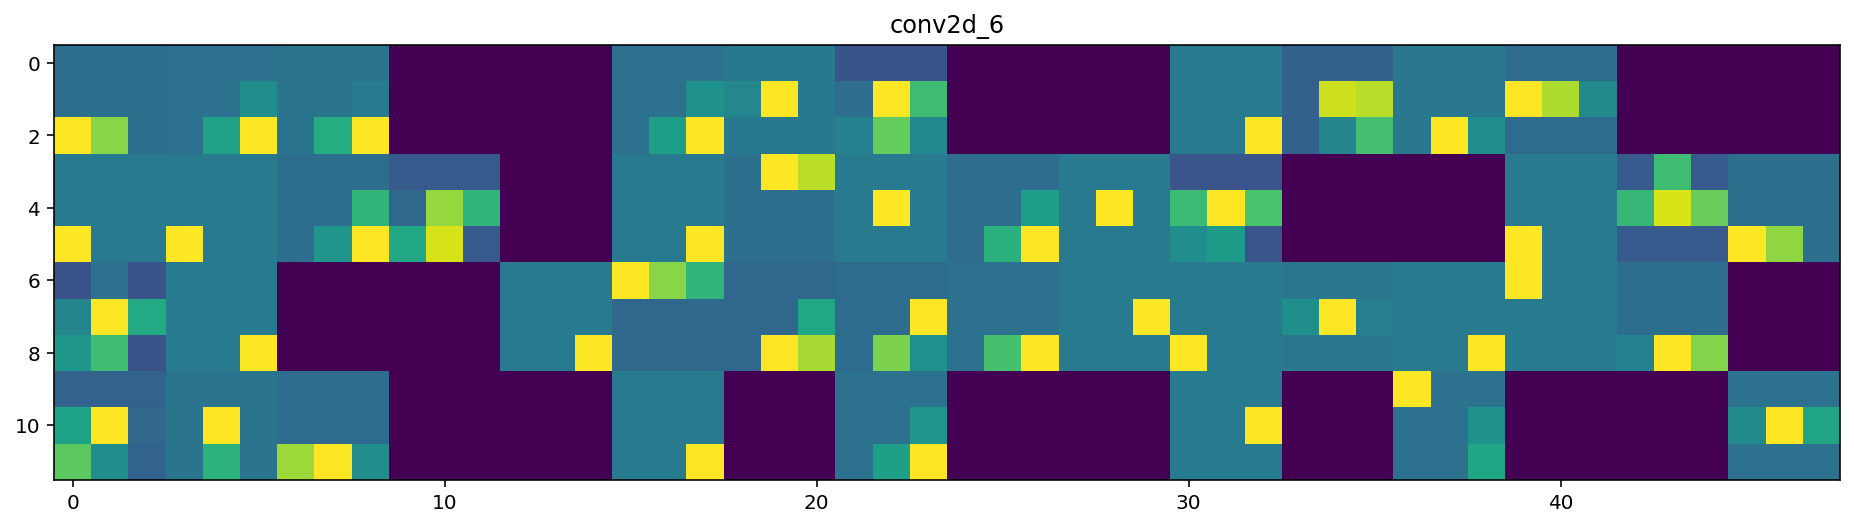

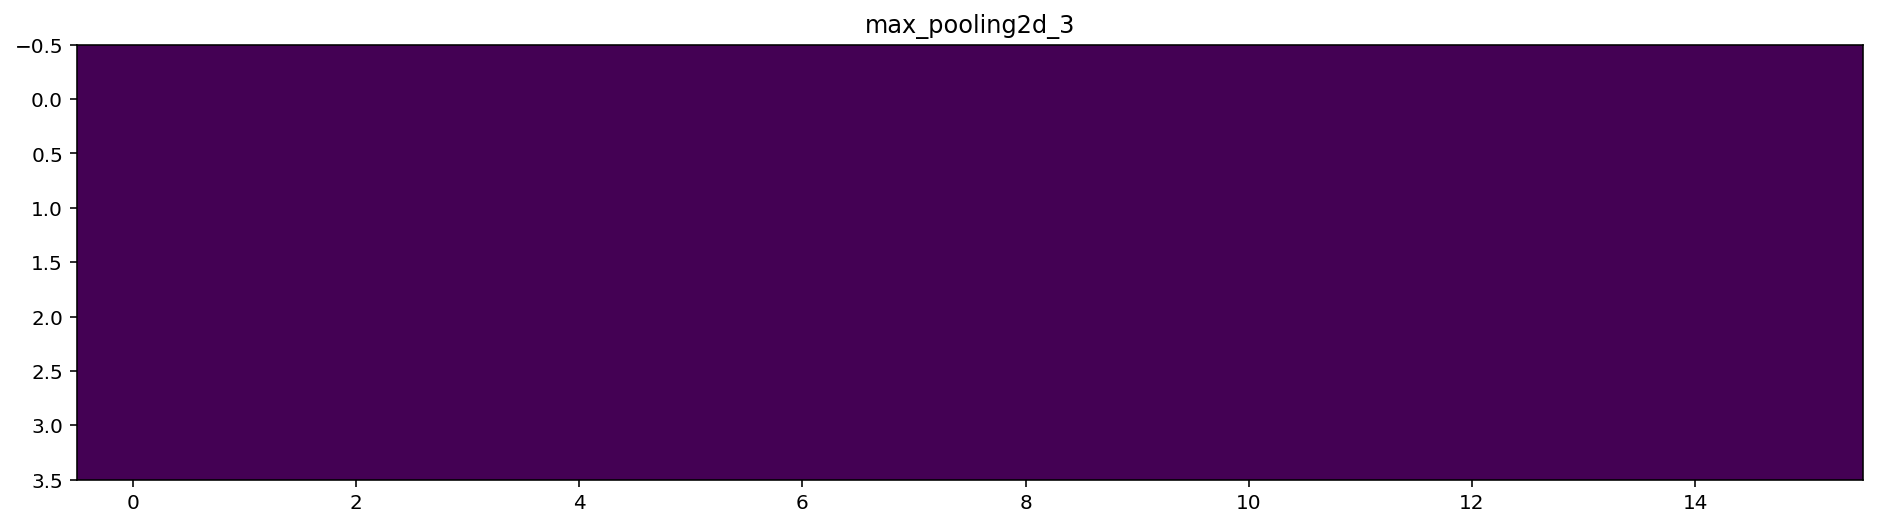

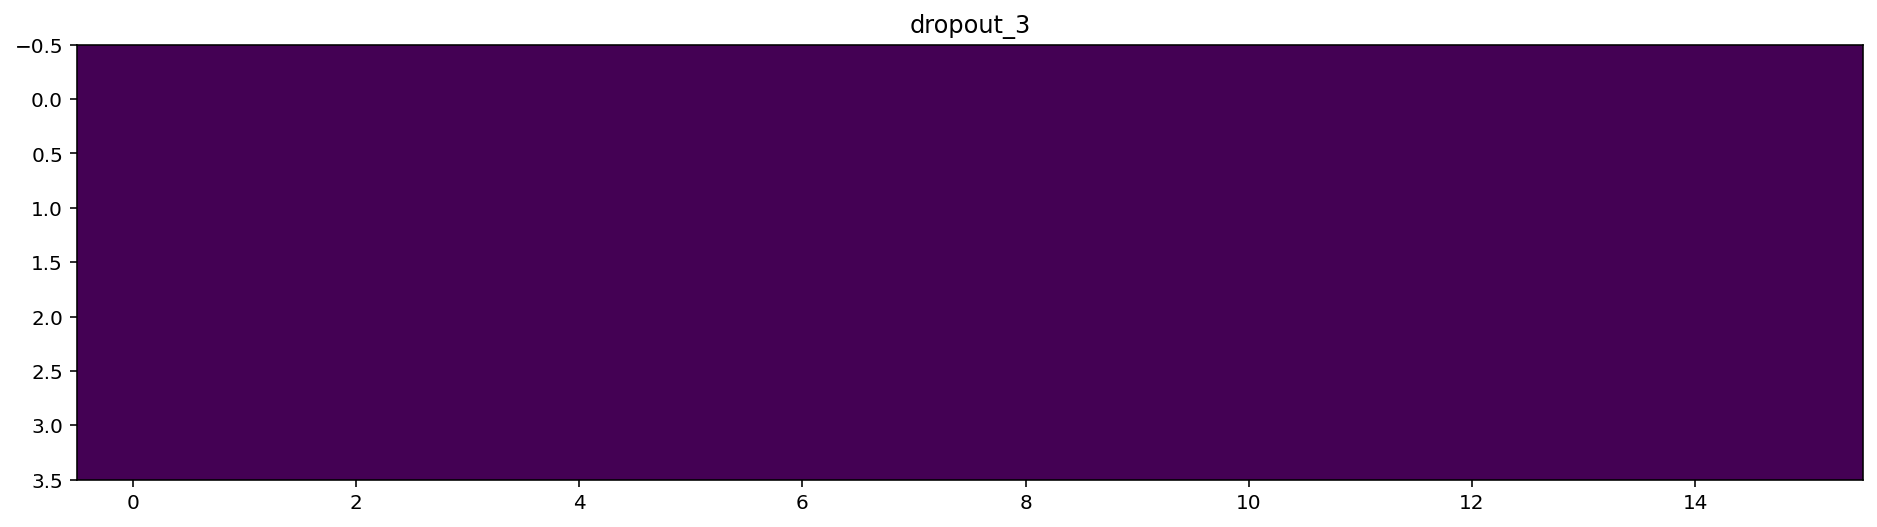

In [23]:
nomes_camadas = []
for camada in model.layers[:12]:
    nomes_camadas.append(camada.name) # para puder colocar o nome da cada camada nas visualizações

imagens_por_linha = 16

for nome_camada, ativacao_camada in zip(nomes_camadas, activations): # o zip permite iterar simultaneamente em 2 listas
    n_features = ativacao_camada.shape[-1] # Numero de features no feature map, pois é o que está na ultima dimensão
    size = ativacao_camada.shape[1] #O feature map tem shape (1, tamanho, tamanho, numero_features).
    n_linhas = -(-n_features // imagens_por_linha) # Empilha os canais de ativação nesta matriz
    print("nome_camada:",nome_camada)
    print("n_features:",n_features)
    print("size:",size)
    print("n_linhas:",n_linhas)
    display_grid = np.zeros((size * n_linhas, imagens_por_linha * size))
    for col in range(n_linhas): # para fazer o display com 15 imagens por linha
        for lin in range(imagens_por_linha):
            #verificar aqui se a imagem existe
            imagem = ativacao_camada[0,:,:,col * imagens_por_linha + lin] #isto pode dar erro de out-of-range
            imagem -= imagem.mean() # pos-processamento para melhor visualização
            imagem /= imagem.std()
            imagem *= 64
            imagem += 128
            imagem = np.clip(imagem, 0, 255).astype('uint8') #valores <0 ficam 0 e >255 ficam = 255
            display_grid[col * size : (col + 1) * size,lin * size : (lin + 1) * size] = imagem
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(nome_camada)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')            
